In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install keras-preprocessing
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 18.3 MB/s eta 0:00:00


In [6]:
import os
import re
import requests
import zipfile
import io
import codecs
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, LSTM, Bidirectional
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [7]:
#load dataset
path = '/content/drive/MyDrive/Modera/dataset_moderaAI.txt'

import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

#inisialisasi stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def get_data(path):
  data = []
  with open(path, 'r', encoding='utf-8') as file:
    lines = file.readlines()
    for line in lines:
      #format file: question \t answer
      question, answer = line.strip().split('\t')
      data.append((question, answer))
  return data


#clean data
def clean_data(data_to_clean, lemmatize=False):
  text = data_to_clean.lower() #---lower case
  text = re.sub(r"[^a-zA-Z0-9\s<>]", "", text)
  words = text.split()
  if lemmatize:
    words = [stemmer.stem(word) for word in words]
  return ' '.join(words)

#clean question answer
def clean_q_and_a(conversations):
  ctx_and_target = []
  for question, answer in (conversations):
    cleaned_question = clean_data(question, lemmatize=False) #non aktifkan lemma question
    cleaned_answer = '<START> ' + clean_data(answer, lemmatize=False) + ' <END>'
    ctx_and_target.append((cleaned_question, cleaned_answer))

  #pisahkan jadi list question n answer
  context, target = zip(*ctx_and_target)
  return list(context), list(target)

#get all conversation
data = get_data(path)

#bersihkan question n answer
cleaned_questions, cleaned_answers = clean_q_and_a(data)

#preview
print("Pertanyaan Bersih (stemmed) :", cleaned_questions[:5])
print("Jawaban Bersih :", cleaned_answers[:5])

Pertanyaan Bersih (stemmed) : ['apa itu moderasi beragama', 'apa itu moderasi beragama', 'bagaimana anda menjelaskan konsep moderasi beragama', 'bagaimana anda menjelaskan konsep moderasi beragama', 'tolong definisikan apa yang dimaksud dengan moderasi beragama']
Jawaban Bersih : ['<START> moderasi beragama adalah cara pandang atau sikap dalam menjalankan agama yang mengedepankan keseimbangan toleransi dan penghormatan terhadap perbedaan <END>', '<START> moderasi beragama adalah cara pandang atau sikap dalam menjalankan agama yang mengedepankan keseimbangan toleransi dan penghormatan terhadap perbedaan <END>', '<START> moderasi beragama adalah cara pandang atau sikap dalam menjalankan agama yang mengedepankan keseimbangan toleransi dan penghormatan terhadap perbedaan <END>', '<START> moderasi beragama adalah cara pandang atau sikap dalam menjalankan agama yang mengedepankan keseimbangan toleransi dan penghormatan terhadap perbedaan <END>', '<START> moderasi beragama adalah cara pandang

In [8]:
#Random Shuffle dataset
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences

combined_data = list(zip(cleaned_questions, cleaned_answers))
random.shuffle(combined_data)

#pisahkan lagi pertanyaan yg udah diacak
shuffled_questions, shuffled_answers = zip(*combined_data)

#preview
print("Pertanyaan Setelah Diacak :", shuffled_questions[:5])
print("Jawaban Setelah Diacak :", shuffled_answers[:5])

Pertanyaan Setelah Diacak : ('apa peran generasi muda dalam moderasi beragama', 'apa saja hambatan yang membuat perempuan sulit berpartisipasi dalam moderasi beragama', 'peran apa yang dimainkan indonesia sebagai teladan moderasi beragama di kancah internasional', 'mengapa aplikasi berbasis agama penting dalam mempromosikan moderasi beragama', 'mengapa moderasi beragama sangat efektif dalam meredam konflik budayaagama')
Jawaban Setelah Diacak : ('<START> generasi muda dapat menjadi agen perubahan dengan menyebarkan nilainilai toleransi melalui media sosial dan kegiatan komunitas <END>', '<START> tantangan meliputi stereotip gender kurangnya pendidikan dan tekanan budaya patriarki <END>', '<START> indonesia aktif mempromosikan toleransi melalui organisasi internasional seperti asean dan pbb <END>', '<START> aplikasi ini dapat digunakan untuk menyebarkan ajaran agama yang moderat dan mendukung kerukunan <END>', '<START> dengan mengedepankan dialog dan menghargai tradisi yang ada selama t

In [9]:
# Contoh data sebelum pengacakan
print("Data Pertanyaan Sebelum Pengacakan:")
for i in range(20):  # Cetak lima contoh pertama
    print(cleaned_questions[i])

print("\nData Jawaban Sebelum Pengacakan:")
for i in range(20):  # Cetak lima contoh pertama
    print(cleaned_answers[i])

# Contoh data setelah pengacakan
print("\nData Pertanyaan Setelah Pengacakan:")
for i in range(20):  # Cetak lima contoh pertama
    print(shuffled_questions[i])

print("\nData Jawaban Setelah Pengacakan:")
for i in range(20):  # Cetak lima contoh pertama
    print(shuffled_answers[i])

Data Pertanyaan Sebelum Pengacakan:
apa itu moderasi beragama
apa itu moderasi beragama
bagaimana anda menjelaskan konsep moderasi beragama
bagaimana anda menjelaskan konsep moderasi beragama
tolong definisikan apa yang dimaksud dengan moderasi beragama
tolong definisikan apa yang dimaksud dengan moderasi beragama
apa pengertian dari sikap beragama yang moderat
apa pengertian dari sikap beragama yang moderat
konsep seperti apa yang diusung oleh moderasi beragama
konsep seperti apa yang diusung oleh moderasi beragama
jelaskan secara singkat apa inti dari moderasi beragama
jelaskan secara singkat apa inti dari moderasi beragama
mengapa moderasi beragama penting
mengapa moderasi beragama penting
apa alasan utama moderasi beragama dianggap penting
apa alasan utama moderasi beragama dianggap penting
kenapa sikap moderat dalam beragama sangat dibutuhkan
kenapa sikap moderat dalam beragama sangat dibutuhkan
apa fungsi moderasi beragama dalam masyarakat
apa fungsi moderasi beragama dalam masya

In [10]:
#cek total data
print(f'Total conversations in dataset: {len(cleaned_questions)}')

Total conversations in dataset: 2502


In [11]:
#data restructuring

tokenizer = Tokenizer()
tokenizer.fit_on_texts(shuffled_questions + shuffled_answers)

VOCAB_SIZE = len(tokenizer.word_index) + 1
print(f'VOCAB SIZE: {VOCAB_SIZE}')

VOCAB SIZE: 1247


In [12]:
from copy import deepcopy

#encoder input
tokenized_questions = tokenizer.texts_to_sequences(shuffled_questions)
maxlen_questions = max([len(x) for x in tokenized_questions])
encoder_input_data = pad_sequences(tokenized_questions, maxlen=maxlen_questions, padding='post') # -> udah ok

#decoder input
tokenized_answers = tokenizer.texts_to_sequences(shuffled_answers)
maxlen_answers = max([len(x) for x in tokenized_answers])
decoder_input_data = pad_sequences(tokenized_answers, maxlen=maxlen_answers, padding='post') #-> udah ok
decoder_target_sequences = deepcopy(tokenized_answers)

# Lakukan pergeseran: Hapus token pertama ('<START>') dari setiap urutan.
for i in range(len(decoder_target_sequences)):
    # Ambil semua elemen KECUALI elemen pertama (indeks 0)
    decoder_target_sequences[i] = decoder_target_sequences[i][1:]

# Lakukan padding pada data target yang sudah digeser
decoder_output_data = pad_sequences(decoder_target_sequences,
                                    maxlen=maxlen_answers,
                                    padding='post')

print("✅ Penyiapan data tokenizer untuk Seq2Seq berhasil!")

✅ Penyiapan data tokenizer untuk Seq2Seq berhasil!


In [13]:
# Tampilkan maxlen_questions
print(f"Max Length for Questions (maxlen_questions): {maxlen_questions}")

# Tampilkan maxlen_answers
print(f"Max Length for Answers (maxlen_answers): {maxlen_answers}")

Max Length for Questions (maxlen_questions): 17
Max Length for Answers (maxlen_answers): 25


In [14]:
#save tokenizer
import pickle

with open('tokenizer.pkl', 'wb') as tokenizer_file:
  pickle.dump(tokenizer, tokenizer_file)

print("Tokenizer berhasil disimpan!")

Tokenizer berhasil disimpan!


In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Concatenate, Dot, Activation, Dropout
from tensorflow.keras.models import Model

#parameter
HIDDEN_DIM = 100
EMBED_DIM = 64
DROPOUT = 0.2

#run ini aja ya
def model(vocab_size, embed_dim=EMBED_DIM, dropout_rate=DROPOUT):
    # Encoder
    enc_inputs = Input(shape=(None,), name='encoder_input')
    # Layer Embedding Encoder (index 2)
    enc_embedding = Embedding(vocab_size, embed_dim, mask_zero=True, name='enc_embedding')(enc_inputs)
    enc_outputs, forward_h, forward_c, backward_h, backward_c = Bidirectional(
        LSTM(HIDDEN_DIM, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        name='encoder_bilstm'
    )(enc_embedding)

    state_h = Concatenate(name='concat_h')([forward_h, backward_h])
    state_c = Concatenate(name='concat_c')([forward_c, backward_c])
    enc_states = [state_h, state_c]

    # Decoder
    dec_inputs = Input(shape=(None,), name='decoder_input')
    # Layer Embedding Decoder (index 3)
    dec_embedding_layer = Embedding(vocab_size, embed_dim, mask_zero=True, name='dec_embedding')
    dec_embedding = dec_embedding_layer(dec_inputs)

    dec_lstm = LSTM(HIDDEN_DIM * 2, return_sequences=True, return_state=True, dropout=dropout_rate, recurrent_dropout=dropout_rate, name='decoder_lstm')
    dec_outputs, _, _ = dec_lstm(dec_embedding, initial_state=enc_states)

    # Attention
    attention = Dot(axes=[2, 2], name='attention_score')([dec_outputs, enc_outputs])
    attention = Activation('softmax', name='attention_weights')(attention)
    context = Dot(axes=[2, 1], name='context_vector')([attention, enc_outputs])

    # Merge context + decoder output
    dec_combined_context = Concatenate(axis=-1, name='combined_context')([context, dec_outputs])
    dec_combined_context = Dropout(dropout_rate)(dec_combined_context)

    # Final prediction (dense layer)
    dec_dense = Dense(vocab_size, activation='softmax', name='output_layer')
    output = dec_dense(dec_combined_context)

    # Define model. Kembalikan LAYER objek juga.
    full_model = Model(inputs=[enc_inputs, dec_inputs], outputs=output)
    return full_model, enc_inputs, enc_outputs, enc_states, dec_inputs, dec_embedding_layer, dec_lstm, dec_dense

In [16]:
# Kompilasi Model
model_lstm = model(vocab_size=VOCAB_SIZE)[0]
model_lstm.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model_lstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_embedding       │ (None, None, 64)  │     79,808 │ encoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ encoder_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_input       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_bilstm      │ [(None, None,     │    132,000 │ enc_embedding[0]… │
│ (Bidirectional)     │ 200), (None,      │            │ not_equal[0][0]   │
│                     │ 100), (None,      │            │                   │
│                     │ 100), (None,      │            │                   │
│                     │ 100), (None,      │            │                   │
│                     │ 100)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_embedding       │ (None, None, 64)  │     79,808 │ decoder_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_h            │ (None, 200)       │          0 │ encoder_bilstm[0… │
│ (Concatenate)       │                   │            │ encoder_bilstm[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_c            │ (None, 200)       │          0 │ encoder_bilstm[0… │
│ (Concatenate)       │                   │            │ encoder_bilstm[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, None,     │    212,000 │ dec_embedding[0]… │
│                     │ 200), (None,      │            │ concat_h[0][0],   │
│                     │ 200), (None,      │            │ concat_c[0][0]    │
│                     │ 200)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_score     │ (None, None,      │          0 │ decoder_lstm[0][… │
│ (Dot)               │ None)             │            │ encoder_bilstm[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, None,      │          0 │ attention_score[… │
│ (Activation)        │ None)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_vector      │ (None, None, 200) │          0 │ attention_weight… │
│ (Dot)               │                   │            │ encoder_bilstm[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ combined_context    │ (None, None, 400) │          0 │ context_vector[0… │
│ (Concatenate)       │                   │            │ decoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, None, 400) │          0 │ combined_context… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, None,      │    500,047 │ dropout[0][0]     │
│ (Dense)             │ 1247)             │            │                 

 Total params: 1,003,663 (3.83 MB)

 Trainable params: 1,003,663 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
#train the model

EPOCHS = 100
BATCH_SIZE = 16

print(f"\n Start train the model with batch size {BATCH_SIZE}")
history = model_lstm.fit(
    [encoder_input_data, decoder_input_data],
    decoder_output_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.2
)
print("\n Training Completed!")


 Start train the model with batch size 16
Epoch 1/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 44s 219ms/step - accuracy: 0.4552 - loss: 4.5219 - val_accuracy: 0.5274 - val_loss: 2.7547
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 211ms/step - accuracy: 0.5463 - loss: 2.6627 - val_accuracy: 0.5525 - val_loss: 2.5051
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.5634 - loss: 2.4191 - val_accuracy: 0.5760 - val_loss: 2.2752
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 28s 220ms/step - accuracy: 0.5773 - loss: 2.2113 - val_accuracy: 0.5894 - val_loss: 2.0796
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 211ms/step - accuracy: 0.5965 - loss: 1.9895 - val_accuracy: 0.6096 - val_loss: 1.8416
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 27s 211ms/step - accuracy: 0.6162 - loss: 1.7731 - val_accuracy: 0.6307 - val_loss: 1.6667
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 41s 212ms/step - accuracy: 0.6388 - loss: 1.5938 - val_accuracy: 0.6623 - val_loss: 1.4625
Epoch 8/100
126/126 ━━━━━━━━━━━━━

In [18]:
#save model weights
model_lstm.save_weights('bi_lstm.weights.h5')
print("Model weights saved successfully.")

Model weights saved successfully.


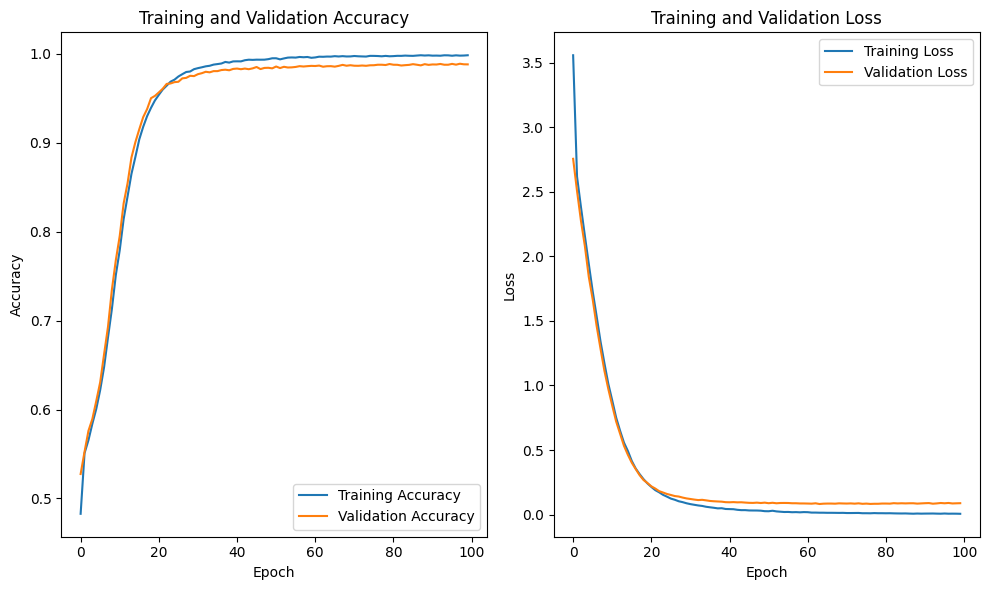

In [20]:
#visualisasi
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))


#akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

#loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.savefig("training_visualization.png", dpi=300)
plt.show()

In [21]:
def make_inference_models(vocab_size):
    full_model, enc_inputs, enc_outputs, enc_states, dec_inputs, dec_embedding_layer, dec_lstm, dec_dense = model(vocab_size)

    full_model.load_weights(f"./bi_lstm.weights.h5")

    # Model ini mengambil input (pertanyaan) dan mengembalikan output encoder dan final states
    enc_model = Model(enc_inputs, [enc_outputs] + enc_states)
    # Input tambahan untuk decoder inference
    enc_out_input = Input(shape=(None, HIDDEN_DIM*2), name='encoder_output_inf')
    dec_state_input_h = Input(shape=(HIDDEN_DIM*2,), name='decoder_state_h_inf')
    dec_state_input_c = Input(shape=(HIDDEN_DIM*2,), name='decoder_state_c_inf')
    dec_states_inputs = [dec_state_input_h, dec_state_input_c]
    dec_emb2 = dec_embedding_layer(dec_inputs)

    # LSTM Decoder
    dec_outputs2, state_h2, state_c2 = dec_lstm(dec_emb2, initial_state=dec_states_inputs)

    # Attention di dalam decoder inference
    attention2 = Dot(axes=[2, 2])([dec_outputs2, enc_out_input])
    attention2 = Activation('softmax')(attention2)
    context2 = Dot(axes=[2, 1])([attention2, enc_out_input])
    dec_combined_context2 = Concatenate(axis=-1)([context2, dec_outputs2])

    # Dense Layer untuk prediksi kata
    dec_outputs2 = dec_dense(dec_combined_context2)

    dec_model = Model(
        [dec_inputs, enc_out_input] + dec_states_inputs,
        [dec_outputs2, state_h2, state_c2]
    )

    return enc_model, dec_model

# Inisialisasi model
encoder_model, decoder_model = make_inference_models(VOCAB_SIZE)

In [22]:
def str_to_tokens(sentence: str):
    words = sentence.lower().split()
    tokens_list = [tokenizer.word_index.get(w, 0) for w in words if tokenizer.word_index.get(w, 0) > 0]
    return pad_sequences([tokens_list], maxlen=maxlen_questions, padding='post')
try:
    START_TOKEN_STR = '<start>'
    END_TOKEN_STR = '<end>'
    START_TOKEN_INDEX = tokenizer.word_index[START_TOKEN_STR]
    END_TOKEN_INDEX = tokenizer.word_index[END_TOKEN_STR]
except KeyError:
    START_TOKEN_STR = 'start'
    END_TOKEN_STR = 'end'
    START_TOKEN_INDEX = tokenizer.word_index[START_TOKEN_STR]
    END_TOKEN_INDEX = tokenizer.word_index[END_TOKEN_STR]

# Buat reverse_word_index untuk mapping yang efisien
reverse_word_index = {v: k for k, v in tokenizer.word_index.items()}
print("\n--- Chatbot Inference Aktif ---")
print(f"Menggunakan token START: '{START_TOKEN_STR}', END: '{END_TOKEN_STR}'")

while True:
    input_text = input("You: ")
    if input_text.lower() == "exit":
        break

    # Hilangkan verbose=0 jika Anda ingin melihat output progress bar
    enc_outs, h, c = encoder_model.predict(str_to_tokens(input_text), verbose=0)
    states_values = [h, c]
    empty_target_seq = np.zeros((1, 1))

    # KOREKSI UTAMA: Menggunakan index token yang sudah ditentukan
    empty_target_seq[0, 0] = START_TOKEN_INDEX

    stop_condition = False
    decoded_sentence = ""

    while not stop_condition:
        # Hilangkan verbose=0 jika Anda ingin melihat output progress bar
        dec_outputs, h, c = decoder_model.predict([empty_target_seq, enc_outs] + states_values, verbose=0)
        sampled_token_index = np.argmax(dec_outputs[0, -1, :])

        # Mapping Index ke Kata (menggunakan reverse_word_index yang lebih cepat)
        sampled_word = reverse_word_index.get(sampled_token_index)

        # 1. Kriteria Penghentian
        # Hentikan jika memprediksi token END
        if sampled_token_index == END_TOKEN_INDEX:
            stop_condition = True
        # Hentikan jika mencapai max length jawaban
        elif len(decoded_sentence.split()) >= maxlen_answers:
            stop_condition = True

        # 2. Pembangun Kalimat
        # Tambahkan kata ke kalimat (hindari penambahan token start/end atau token tak dikenal)
        elif sampled_word is not None and sampled_token_index != START_TOKEN_INDEX:
            # Hilangkan token khusus dari output yang ditampilkan
            if sampled_word not in [START_TOKEN_STR, END_TOKEN_STR]:
                decoded_sentence += sampled_word + " "

        # 3. SIAPKAN INPUT DECODER BERIKUTNYA
        empty_target_seq = np.zeros((1, 1))
        empty_target_seq[0, 0] = sampled_token_index
        states_values = [h, c]

    print("Chatbot:", decoded_sentence.strip())


--- Chatbot Inference Aktif ---
Menggunakan token START: 'start', END: 'end'
You: selamat siang
Chatbot: selamat siang juga
You: nama kamu siapa?
Chatbot: hai saya modera ai
You: siapa kamu
Chatbot: saya dikembangkan oleh tim riset universitas islam negeri sultan syarif kasim riau
You: exit


In [25]:
# === Setelah build inference model ===
encoder_model.save("encoder_model.h5")
decoder_model.save("decoder_model.h5")

print("✅ Encoder & Decoder inference models saved!")

✅ Encoder & Decoder inference models saved!


In [24]:
import json

# Asumsi model_lstm adalah model Keras yang sudah Anda latih
# Pastikan Anda sudah menjalankan model.py untuk mendapatkan fungsi create_model_architecture
# Anda perlu memanggil fungsi ini di Colab Anda:
# model_lstm = create_model_architecture(VOCAB_SIZE)[0]

def save_model_architecture(model_lstm, filename='full_model_architecture.json'):
    # Konversi arsitektur ke JSON string
    model_json = model_lstm.to_json()

    # Simpan ke file
    with open(filename, "w") as json_file:
        json_file.write(model_json)
    print(f"[*] Arsitektur model berhasil disimpan sebagai {filename}")

# Contoh memanggil fungsi ini di Colab Anda
save_model_architecture(model_lstm)

[*] Arsitektur model berhasil disimpan sebagai full_model_architecture.json


In [ ]:
pip freeze > requirements.txt
